In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import logging
import re

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print("No compatible GPUs found")

1 Physical GPUs, 1 Logical GPUs


## Common constants

In [35]:
IMG_W = 32
IMG_H = 32
IMG_C = 1

last_epoch = 0
batch_size = 128
latent_dim = 128
SAMPLES_PATH = "samples_old"
CHECKPOINT_PATH = "saved_model_old"
LOG_DIR = "/qarr/studia/magister/models/gan_logs"

In [36]:
try:
    checkpoints = os.listdir(CHECKPOINT_PATH)
    last_epoch = np.max([int(re.search(r"-[0-9]+\.", i)[0][1:-1]) for i in checkpoints if
                             re.search(r"-[0-9]+\.", i)])
    print("Detected {} epoch as last checkpoint".format(last_epoch))
except (ValueError,  FileNotFoundError):
    last_epoch = 0
    print("Did not detect any checkpoints to continue from")

Did not detect any checkpoints to continue from


## Loading the dataset

In [5]:
learning_set = np.fromfile('fashion_mnist/train-images-idx3-ubyte', dtype='uint8')
learning_lab = np.fromfile('fashion_mnist/train-labels-idx1-ubyte', dtype='uint8')
test_set = np.fromfile('fashion_mnist/t10k-images-idx3-ubyte', dtype='uint8')
test_lab = np.fromfile('fashion_mnist/t10k-labels-idx1-ubyte', dtype='uint8')

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [8]:
train_examples = 60000
test_examples = 10000
batch_size = 128

resized_train = np.zeros((train_examples, 32, 32))
for i in range(train_examples):
    resized_train[i] = cv2.resize(np.reshape(learning_set[16+28*28*i:16+28*28*(i+1)], (28,28,1)), (32, 32))
resized_train = np.resize(resized_train, (60000, 32, 32, 1))

train_dataset = tf.data.Dataset.from_tensor_slices(resized_train)
def normalize(images):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images

train_dataset =  train_dataset.map(normalize)
train_dataset = train_dataset.cache().repeat().shuffle(train_examples).batch(batch_size)

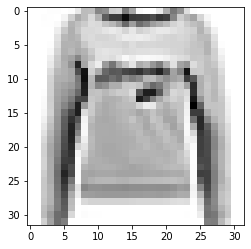

In [9]:
plt.imshow(train_dataset.as_numpy_iterator().next()[0], cmap=plt.cm.binary)

(array([372.,  15.,  38.,  20.,  46.,  62., 192., 174.,  71.,  34.]),
 array([0.        , 0.08392157, 0.16784313, 0.2517647 , 0.33568627,
        0.41960785, 0.5035294 , 0.587451  , 0.67137253, 0.75529414,
        0.8392157 ], dtype=float32),
 <BarContainer object of 10 artists>)

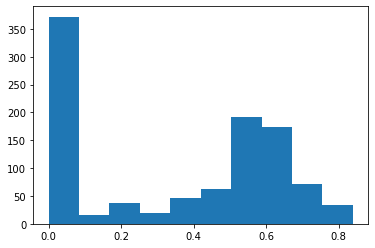

In [10]:
plt.hist(np.ravel(train_dataset.as_numpy_iterator().next()[0]))

### Common helper functions and clearing session

In [50]:
from commons import *
weight_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [51]:
def save_plot(examples, epoch, n):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, i+1)
        plt.axis("off")
        plt.imshow(examples[i])
    if not os.path.exists(SAMPLES_PATH):
        os.mkdir(SAMPLES_PATH)
    filename = f"{SAMPLES_PATH}/generated_plot_epoch-{epoch+1}.png"
    plt.savefig(filename)
    plt.close()

In [38]:
tf.keras.backend.clear_session()

checkpoint_path_g = f"{CHECKPOINT_PATH}/gencp-{{epoch:02d}}.ckpt"
checkpoint_path_d = f"{CHECKPOINT_PATH}/discp-{{epoch:02d}}.ckpt"

checkpoint_dir = os.path.dirname(checkpoint_path_g)
checkpoint_dir = os.path.dirname(checkpoint_path_d)

In [39]:
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = LOG_DIR, histogram_freq=1)

## Defining the model

In [40]:
d_model = build_discriminator_ref(weight_init, IMG_H=IMG_H, IMG_W=IMG_W, IMG_C=IMG_C)
g_model = build_generator_ref(latent_dim, weight_init, IMG_H=IMG_H, IMG_W=IMG_W, IMG_C=IMG_C)

### Loading the model from last checkpoint, if able

In [41]:
if last_epoch:
    d_model.load_weights(checkpoint_path_d.format(epoch=last_epoch))
    g_model.load_weights(checkpoint_path_g.format(epoch=last_epoch))
    print(f"Loading models from epoch {last_epoch}")
else:
    print("No checkpoint to load from")

No checkpoint to load from


In [ ]:
d_model.summary()

In [46]:
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_noise_input (Input [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              262144    
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         10

In [47]:
class GAN_old(tf.keras.models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN_old, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN_old, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for _ in range(2):
            ## Train the discriminator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            generated_images = self.generator(random_latent_vectors)
            generated_labels = tf.zeros((batch_size, 1))

            with tf.GradientTape() as ftape:
                predictions = self.discriminator(generated_images)
                d1_loss = self.loss_fn(generated_labels, predictions)
            grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

            ## Train the discriminator
            labels = tf.ones((batch_size, 1))

            with tf.GradientTape() as rtape:
                predictions = self.discriminator(real_images)
                d2_loss = self.loss_fn(labels, predictions)
            grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        ## Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as gtape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = gtape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d1_loss": d1_loss, "d2_loss": d2_loss, "g_loss": g_loss, "total":d1_loss+d2_loss+g_loss}

In [42]:
train_for = 200 # epochs to train

In [48]:
gan = GAN_old(d_model, g_model, latent_dim)
bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
gan.compile(d_optimizer, g_optimizer, bce_loss_fn)

In [52]:
n_samples = 25
noise = np.random.normal(size=(n_samples, latent_dim))

logging.getLogger('tensorflow').setLevel(logging.ERROR)
try:
    for epoch in range(last_epoch, last_epoch+train_for):
        gan.fit(train_dataset, 
                initial_epoch=epoch, 
                epochs=epoch+1, 
                batch_size=batch_size, 
                steps_per_epoch=train_examples//batch_size,
                callbacks=[tboard_callback]
               )
        g_model.save_weights(checkpoint_path_g.format(epoch=epoch+1))
        d_model.save_weights(checkpoint_path_d.format(epoch=epoch+1))

        n_samples = 25
        new_noise = np.random.normal(size=(n_samples, latent_dim))
        new_noise[0:5] = noise[0:5]
        examples = g_model.predict(new_noise)
        save_plot(examples, epoch, int(np.sqrt(n_samples)))
except KeyboardInterrupt:
    print("Interrupted")
    
last_epoch += train_for

logging.getLogger('tensorflow').setLevel(logging.WARNING)

468/468 [==============================] - 87s 186ms/step - d1_loss: 0.2216 - d2_loss: 0.2620 - g_loss: 2.4082 - total: 2.8919
Epoch 2/2
468/468 [==============================] - 88s 189ms/step - d1_loss: 0.2277 - d2_loss: 0.2370 - g_loss: 2.5942 - total: 3.0589
Epoch 3/3
468/468 [==============================] - 88s 188ms/step - d1_loss: 0.2283 - d2_loss: 0.2448 - g_loss: 2.5924 - total: 3.0655
Epoch 4/4
468/468 [==============================] - 88s 188ms/step - d1_loss: 0.2285 - d2_loss: 0.2525 - g_loss: 2.5029 - total: 2.9840
Epoch 5/5
468/468 [==============================] - 88s 188ms/step - d1_loss: 0.2323 - d2_loss: 0.2498 - g_loss: 2.5899 - total: 3.0719
Epoch 6/6
468/468 [==============================] - 88s 189ms/step - d1_loss: 0.2416 - d2_loss: 0.2459 - g_loss: 2.6625 - total: 3.1499
Epoch 7/7
468/468 [==============================] - 88s 188ms/step - d1_loss: 0.2393 - d2_loss: 0.2476 - g_loss: 2.5845 - total: 3.0714
Epoch 8/8
468/468 [==============================] 

KeyboardInterrupt: 